# Threshold Tools: Defining and analyzing custom extreme events

A notebook for defining and analyzing different types of extreme events using the `get_block_maxima` function in `threshold_tools`. For a basic introduction and explanations of the functions in the `threshold_tools` module, see the notebook [threshold_basics.ipynb](../work-in-progress/threshold_basics.ipynb)

This notebook calculates the Block Maximum Series for 4 differently defined extreme events (Step 2), then proceeds with extreme value analysis for each of the 4 event types (Step 3).

This notebook also includes a discussion of some of the relevant underlying assumptions of extreme value theory, in particular around the effective sample size of the data that is used in the block maxima approach (under example 3 in Step 2).

The 4 differently defined extreme events used as examples in this notebook are:
- Example 1: hottest hour in each year
- Example 2: the hottest continuous 3-hour event in each year
- Example 3: the hottest temperature that is reached 3 days in a row
- Example 4: hottest temperature that is reached for 4 hours a day, for 3 days in a row

**Intended Application**: As a user, I want to understand the expected frequency of different types of extreme events.

**Runtime**: With the default settings, this notebook takes approximately **2 minutes** to run from start to finish. Modifications to selections may increase the runtime.

<a id='setup'></a>
## Step 0: Setup

Import needed libraries and functions.

In [2]:
import panel as pn
pn.extension()
import matplotlib.pyplot as plt

import climakitae as ck
import climakitaegui as ckg
from climakitae.explore import threshold_tools
from climakitae.explore.threshold_tools import get_block_maxima, get_return_value, get_return_period

<a id='sel'></a>
## Step 1: Select and retrieve data of interest

In the code cell below, the `ckg.Select()` function of the `climakitaegui` app displays an interface for data selection.

To perform the example analyses provided later in this notebook, we will set the data retrieval selections to the following: 
- hourly temperature data in degrees Fahrenheit
- SSP 3-7.0, no historical data (you can explore the analysis for other scenarios as well, the choice of SSP 3.7 is for the purpose of this example) 
- choose Sacramento County, and take an area average (the following analyses can also be performed on spatial data, but will take longer to run)

To learn more about the data available on the Analytics Engine, see our [data catalog](https://analytics.cal-adapt.org/data/). The [gettting_started.ipynb](../getting_started.ipynb) notebook contains additional explanations of the data.

In [3]:
selections = ckg.Select()

In [4]:
selections.scenario_historical=[]
selections.scenario_ssp=['SSP 3-7.0']
selections.append_historical = False
selections.variable = 'Air Temperature at 2m'
selections.time_slice = (2015, 2100)
selections.resolution = '9 km'
selections.timescale = 'hourly'
selections.units = 'degF'
selections.downscaling_method = "Dynamical"
selections.area_subset = 'CA counties'
selections.cached_area = ['Sacramento County']
selections.area_average = 'Yes'

### Retrieve data

Run `selections.retrieve()` to load the data selected above.

In [5]:
hourly_data = selections.retrieve()

For the following analysis, we will work with a subset of the data from just one model simulation:

In [6]:
hourly_data_subset = hourly_data.isel(simulation=0, scenario=0)

To speed up the following computations, load the selected subset of data into memory. This step may take a few minutes to compute.

In [7]:
hourly_data_subset = ck.load(hourly_data_subset)

Processing data to read 2.86 MB of data into memory... Complete!


<a id='transform'></a>
## Step 2: Get block maxima series for different event types

To facilitate custom definitions of different types of extreme events, there are optional keyword arguments to the `get_block_maxima` function to pull the maximum annual value. The keyword options are:
- `duration`: how long an event continuously lasts in hours (see example 2)
- `groupby` and  `grouped_duration`: work together to define multi-day events (see examples 3 and 4)

The following four examples show how to use these options to construct different types of events of interest. See section 3 for further analysis and discussion of these events.

### Example 1: hottest hour in each year
The basic use case of `get_block_maxima` pulls the maximum value in each year of data, shown here:

In [8]:
ams = get_block_maxima(hourly_data_subset)

Next, we can vizualize the annual maximum values that we just calculated:

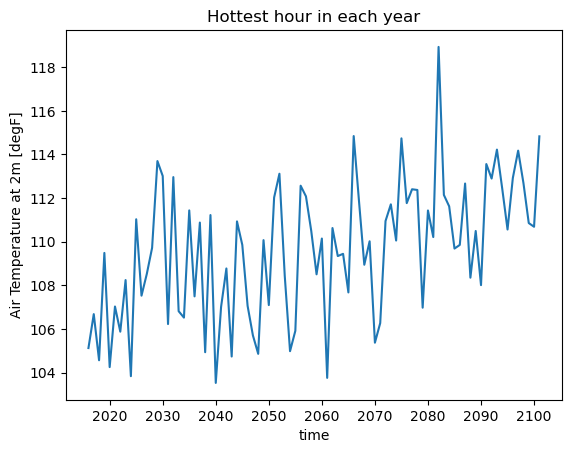

In [9]:
ams.plot()
plt.title('Hottest hour in each year')
plt.show()

### Example 2: the hottest continuous 3-hour event in each year
Users may be interested in extremes that last longer than 1 hour. This example identifies the temperature value that corresponds to the hottest continuous 3-hour period in each year, using the optional `duration` argument. 

In [10]:
ams_3h = get_block_maxima(
    hourly_data_subset,
    duration = (3, 'hour')
)

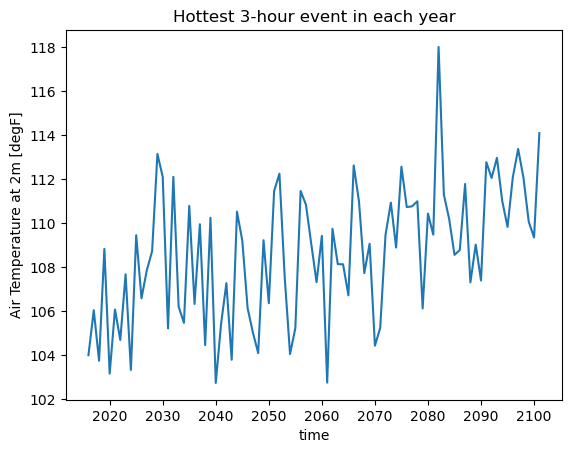

In [11]:
ams_3h.plot()
plt.title('Hottest 3-hour event in each year')
plt.show()

### Example 3: the hottest temperature that is reached 3 days in a row
This example identifies the max temperature value that is reached for at least 1 hour each day for 3 days in a row, using the `groupby` and `grouped_duration` arguments.

In [12]:
ams_3d = get_block_maxima(
    hourly_data_subset,
    groupby = (1, 'day'), 
    grouped_duration = (3, 'day')
)

#### Note: effective sample size
In the above example we see a warning about the effective sample size (ESS) for this event type. Extreme value analysis relies on having enough data to characterize the extremes, which is complicated by the fact that hourly climate data are "autocorrelated", meaning that one hour of data is not independent from the previous hour. This inherent autocorrelation of timeseries data reduces the "effective sample size" of the data, which is an estimate of how many independent data values we have. 

As we specify types of extreme events lasting longer than one hour, the effective sample size of how many of these events there are in each year of data decreases. When the sample size is too small, the underlying assumptions for extreme value analysis may no longer be satisfied, which can result in biased estimates of the distributions of extreme values. This is why the code will display a warning if the average ESS in your blocks of data is less than 25. 

If you are only interested in identifying the maximum extreme value in each year of the data and do not plan to fit an extreme value distribution to the maximums, you can proceed with block size of 1 year, and can suppress the warning with the optional `check_ess=False`. 

However, if you will use these block maxima values for extreme value analysis and the sample size is too low, we recommend increasing the block size, shown in the following code cell. Here we pull the maximum event values in 2-year intervals, instead of annual maximums, using the additional `block_size` argument:

In [13]:
bms_3d = get_block_maxima(
    hourly_data_subset,
    extremes_type='max', 
    groupby=(1, 'day'), 
    grouped_duration = (3, 'day'),
    block_size=2
)

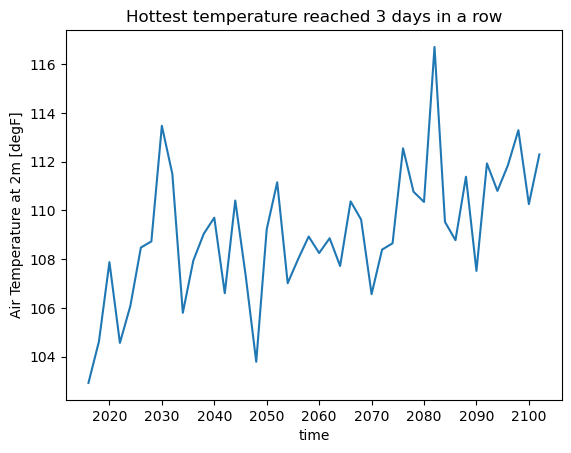

In [14]:
bms_3d.plot()
plt.title('Hottest temperature reached 3 days in a row')
plt.show()

### Example 4: hottest temperature that is reached for 4 hours a day, for 3 days in a row
This example identifies the max temperature value that is reached for at least 4 hours each day for 3 days in a row, using all three optional arguments `duration`, `groupby`, and `grouped_duration`.

In [15]:
ams_4h3d = get_block_maxima(
    hourly_data_subset,
    duration = (4, 'hour'), 
    groupby = (1, 'day'), 
    grouped_duration = (3, 'day')
)

In this example event type, we also see the warning about low effective sample size. We will proceed with using a block size of 2 years for this event type as well:

In [16]:
bms_4h3d = get_block_maxima(
    hourly_data_subset,
    duration = (4, 'hour'), 
    groupby = (1, 'day'), 
    grouped_duration = (3, 'day'),
    block_size = 2
)

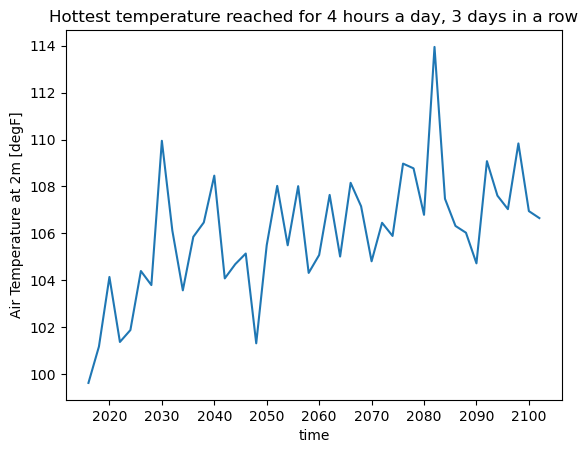

In [17]:
bms_4h3d.plot()
plt.title('Hottest temperature reached for 4 hours a day, 3 days in a row')
plt.show()

## Step 3: Proceed with Extreme Value Analysis on the different event types

Using the block maxima series calculated for each of the event types in Step 2, we can now calculate return values and probabilities for each of the four event types. Further discussion of these extreme value analysis functions can be found in the [threshold_basics.ipynb](../work-in-progress/threshold_basics.ipynb) notebook.

### 1-in-20 Return values
What is the highest temperature value for each event type we expect to experience about once every 20 years? The following four code cells calculate the estimated 1-in-20 return values  for each of the four different event types. The `get_return_value()` function accepts the block maximum series data (computed for each of the four examples in step 2) as the first argument. Notice how the longer event types have lower return values--this represents the fact that extreme distributions for multi-day events will have lower temperature values than extreme distributions for single hour-long events.

**Return value for example 1, hottest hour:**

In [ ]:
get_return_value(ams, return_period=20, multiple_points=False)

**Return value for example 2, hottest 3-hour event:**

In [ ]:
get_return_value(ams_3h, return_period=20, multiple_points=False)

**Return value for example 3, hottest temperature reached 3 days in a row:**

In [ ]:
get_return_value(bms_3d, return_period=20, multiple_points=False)

**Return value for example 4, hottest temperature reached for 4 hours each day 3 days in a row:**

In [ ]:
get_return_value(bms_4h3d, return_period=20, multiple_points=False)

### Return periods
About how often do we expect to experience an event exceeding 105F for each of the four defined event types? The `get_return_period` function returns the estimate, in years, of how frequent these events exceed 105F. Notice that the return period is larger for the longer event types. For example, we expect to experience 3 days in a row that reach 105F (example 3) less frequently than we expect to experience a single hour reaching 105F (example 1).

*Note: if you are performing this analysis for an area other than Sacramento County, you may be interested in a temperature value different than 105F that is more relevant to the local climate.*

**Return period for example 1:**

In [ ]:
get_return_period(ams, return_value=105, multiple_points=False)

**Return period for example 2:**

In [ ]:
get_return_period(ams_3h, return_value=105, multiple_points=False)

**Return period for example 3:**

In [ ]:
get_return_period(bms_3d, return_value=105, multiple_points=False)

**Return period for example 4:**

In [ ]:
get_return_period(bms_4h3d, return_value=105, multiple_points=False)